# Setup

required gspred and oauth

Go to Google Develpment console and create a new project. Go to apis and services and enable google sheets. Go to credentials and create a service account. Access level Viewer. Create and download .json key file. Save keyfile to your project folder. 

In [2]:
from oauth2client.service_account import ServiceAccountCredentials
import gspread
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [141]:
scope = [
    'https://www.googleapis.com/auth/spreadsheets'
]

GOOGLE_KEY_FILE = 'my_api_key.json'

credentials = ServiceAccountCredentials.from_json_keyfile_name(GOOGLE_KEY_FILE, scope)
gc = gspread.authorize(credentials)

workbook_key = '1yZv9w9zRKwrGTaR-YzmAqMefw4wMlaXocejdxZaTs6w' 
workbook = gc.open_by_key(workbook_key)
sheet = workbook.get_worksheet(0)
values = sheet.get_all_values()
c_data_0 = pd.DataFrame(values[1:],columns=values[0])

In [139]:
workbook.worksheets()

[<Worksheet 'Feb01_11pm' id:561110064>,
 <Worksheet 'Feb01_6pm' id:796970490>,
 <Worksheet 'Feb01_10am' id:1525235828>,
 <Worksheet 'Jan31_7pm' id:1562962385>,
 <Worksheet 'Jan31_2pm' id:527706386>,
 <Worksheet 'Jan30_930pm' id:1207243992>,
 <Worksheet 'Jan30_11am' id:1320052203>,
 <Worksheet 'Jan29_9pm' id:536002735>,
 <Worksheet 'Jan29_230pm' id:91004260>,
 <Worksheet 'Jan29_130pm' id:1368739505>,
 <Worksheet 'Jan28_11pm' id:174402790>,
 <Worksheet 'Jan28_6pm' id:1954658351>,
 <Worksheet 'Jan28_1pm' id:1703730149>,
 <Worksheet 'Jan27_830pm' id:1979823633>,
 <Worksheet 'Jan27_7pm' id:2089257782>,
 <Worksheet 'Jan27_9am' id:62708662>,
 <Worksheet 'Jan26_11pm' id:32656279>,
 <Worksheet 'Jan26_11am' id:430379785>,
 <Worksheet 'Jan25_10pm' id:1501063148>,
 <Worksheet 'Jan25_12pm' id:1380010768>,
 <Worksheet 'Jan25_12am' id:76578435>,
 <Worksheet 'Jan24_12pm' id:1511763698>,
 <Worksheet 'Jan24_12am' id:1389232671>,
 <Worksheet 'Jan23_12pm' id:142449061>,
 <Worksheet 'Jan22_12pm' id:6382316

In [142]:
c_data_0.head()

,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
0,Hubei,Mainland China,2/1/2020 23:33,9074,294,215
1,Zhejiang,Mainland China,2/2/2020 2:13,661,0,23
2,Guangdong,Mainland China,2/2/2020 1:23,604,0,14
3,Henan,Mainland China,2/2/2020 0:53,493,2,4
4,Hunan,Mainland China,2/2/2020 1:53,463,0,8


Connection works, test df is ok

# Cleaning and Unioning the whole dataset

Transform 'x_[...]' sheets into a format that can be unioned with newer sheets

* inspect unformated sheets and group edits

In [128]:
#Select all sheets

all_sheet_list =  []

for i in workbook.worksheets():
    all_sheet_list.append(i.title) 

#Select all bad sheets (that are known)    
    
bad_sheet_list = [
    'Feb01_6pm',  # special case - drop last column: (-['Quick note: Starting from this tab, our map is updating (almost) in real time (China data - at least once per hour; non China data - several times per day). This table is planning to be updated twice a day. The discrepancy between the map and this sheet is expected. Sorry for any confusion and inconvenience.'])
    #'Jan26_11pm', #ok
    'Jan26_11am', #(-[''Suspected'])
    'Jan25_10pm', #(-[''Suspected'])
    'Jan25_12pm', #(-[''Suspected'])
    'Jan25_12am', #(-[''Suspected'])
    'Jan24_12pm', #(-[''Suspected'])
    'Jan24_12am', #(-[''Suspected'])
    'Jan23_12pm', # special case - (-[''Suspected']) ('Demised' to 'Deaths')
    'Jan22_12pm', #(-[''Suspected']) (chg. 'Data last updated' to 'Last Update')
    'Jan22_12am'  # special case - (-[''Suspected']) (chg. 'Data last updated' to 'Last Update')
]

#Sub-selection of similar bad sheets with only 1 extra column

bad_sheet_list_01 = [
    'Jan26_11am', #(-[''Suspected'])
    'Jan25_10pm', #(-[''Suspected'])
    'Jan25_12pm', #(-[''Suspected'])
    'Jan25_12am', #(-[''Suspected'])
    'Jan24_12pm', #(-[''Suspected'])
    'Jan24_12am' #(-[''Suspected'])
]

#Select good sheets w. list comprehension

good_sheet_list = [sheet for sheet in all_sheet_list if sheet not in bad_sheet_list]

* transform sheets
* union into complete set

In [129]:
#create empty dataframes to hold sheets
bad_data_df = pd.DataFrame(columns=['Province/State', 'Country/Region', 'Last Update', 'Confirmed','Deaths', 'Recovered'])
good_data_df = pd.DataFrame(columns=['Province/State', 'Country/Region', 'Last Update', 'Confirmed','Deaths', 'Recovered'])

#load sheets with ok format
for i in good_sheet_list:
    temp_ws = workbook.worksheet(i)
    temp_val = temp_ws.get_all_values()
    temp_df = pd.DataFrame(temp_val[1:],columns=temp_val[0])
    #print(i)
    #print(temp_df.head())
    good_data_df = pd.concat([good_data_df, temp_df], axis = 0, ignore_index=True, sort=True)
    
#Load and transform bad sheets

for i in bad_sheet_list:
    if i in bad_sheet_list_01:
        temp_ws = workbook.worksheet(i)
        temp_val = temp_ws.get_all_values()
        temp_df = pd.DataFrame(temp_val[1:],columns=temp_val[0])
        temp_df = temp_df.drop(columns=['Suspected'])
        bad_data_df = pd.concat([bad_data_df, temp_df], axis = 0, ignore_index=True, sort=True)
    elif i == 'Feb01_6pm':
        temp_ws = workbook.worksheet(i)
        temp_val = temp_ws.get_all_values()
        temp_df = pd.DataFrame(temp_val[1:],columns=temp_val[0])
        temp_df = temp_df[['Province/State', 'Country/Region', 'Last Update', 'Confirmed', 'Deaths', 'Recovered']]
        bad_data_df = pd.concat([bad_data_df, temp_df], axis = 0, ignore_index=True, sort=True)
    elif i == 'Jan23_12pm':
        temp_ws = workbook.worksheet(i)
        temp_val = temp_ws.get_all_values()
        temp_df = pd.DataFrame(temp_val[1:],columns=temp_val[0])
        temp_df = temp_df.drop(columns=['Suspected'])
        temp_df = temp_df.rename(columns={'Demised':'Deaths'})
        bad_data_df = pd.concat([bad_data_df, temp_df], axis = 0, ignore_index=True, sort=True)
    elif i in ['Jan22_12am','Jan22_12pm']:
        temp_ws = workbook.worksheet(i)
        temp_val = temp_ws.get_all_values()
        temp_df = pd.DataFrame(temp_val[1:],columns=temp_val[0])
        temp_df = temp_df.drop(columns=['Suspected'])
        temp_df = temp_df.rename(columns={'Date last updated':'Last Update'})
        temp_df = temp_df.rename(columns={'Country':'Country/Region'})
        bad_data_df = pd.concat([bad_data_df, temp_df], axis = 0, ignore_index=True, sort=True)
        
#Union two above DataFrames

complete_union_df = pd.concat([good_data_df, bad_data_df], axis = 0, ignore_index=True, sort=True)

* check data

In [130]:
complete_union_df.describe()

,Confirmed,Country/Region,Deaths,Last Update,Province/State,Recovered
count,1323,1323,1258,1323,1323,1258
unique,177,33,16,75,54,32
top,1,Mainland China,,1/25/2020 12:00 PM,,
freq,230,728,988,86,295,850


In [131]:
complete_union_df.head()

,Confirmed,Country/Region,Deaths,Last Update,Province/State,Recovered
0,9074,Mainland China,294,2/1/2020 23:33,Hubei,215
1,661,Mainland China,0,2/2/2020 2:13,Zhejiang,23
2,604,Mainland China,0,2/2/2020 1:23,Guangdong,14
3,493,Mainland China,2,2/2/2020 0:53,Henan,4
4,463,Mainland China,0,2/2/2020 1:53,Hunan,8


In [132]:
complete_union_df.tail()

,Confirmed,Country/Region,Deaths,Last Update,Province/State,Recovered
1318,,China,NaN,1/21/2020,Heilongjiang,NaN
1319,1,Japan,NaN,1/21/2020,,NaN
1320,2,Thailand,NaN,1/21/2020,,NaN
1321,1,South Korea,NaN,1/21/2020,,NaN
1322,1,United States,NaN,1/21/2020,Washington,NaN


### Write output

In [133]:
complete_union_df.to_csv('complete_union.csv')

# Plotting

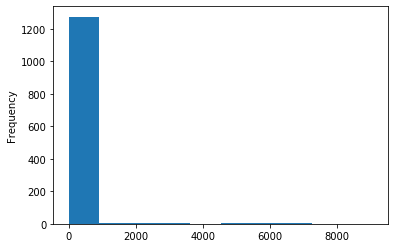

In [121]:
pd.read_csv('complete_union.csv')['Confirmed'].plot.hist()